In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-18T22:18:59.324011+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn import preprocessing

from typing import Tuple

In [4]:
from xgboost import __version__ as xgb_version
from sklearn import __version__ as sklearn_version

print(f'xgb_version: {xgb_version}')
print(f'sklearn_version: {sklearn_version}')

xgb_version: 1.6.1
sklearn_version: 0.24.2


In [5]:
%watermark --iversions

sklearn: 0.24.2
xgboost: 1.6.1
numpy  : 1.20.3
pandas : 0.25.3



## Reproducibility block

In [6]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED = 309487
XGB_RANDOMSEED = 56

In [7]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [8]:
NTRY = 15
NAME = f'{NTRY}_xgb_pca64_sber_lags_parse_bord_nose_irq'

In [9]:
CTR_UKR = 6.096

VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Load data

In [10]:
df_train  = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'), index_col= 0)
x_train  = pd.read_csv(os.path.join(DIR_DATA, 'x_train.csv'), index_col= 0)
x_val    = pd.read_csv(os.path.join(DIR_DATA, 'x_val.csv'), index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'), index_col= 0)

with open(os.path.join(DIR_DATA, 'cat_columns.pkl'), 'rb') as pickle_file:
    cat_cols = pkl.load(pickle_file)
    
with open(os.path.join(DIR_DATA, 'num_columns.pkl'), 'rb') as pickle_file:
    num_cols = pkl.load(pickle_file)
    
with open(os.path.join(DIR_DATA, 'clmns.pkl'), 'rb') as pickle_file:
    clmns = pkl.load(pickle_file)


In [11]:
x_train.shape, x_val.shape, df_test.shape, len(cat_cols), len(num_cols)

((4930, 290), (1233, 290), (3000, 286), 11, 262)

отделяем метки от данных

In [12]:
y_train = x_train[['views', 'depth', 'full_reads_percent']]
y_val   = x_val[['views', 'depth', 'full_reads_percent']]

x_train.drop(['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)
x_val.drop(  ['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((4930, 287), (1233, 287), (4930, 3), (1233, 3))

In [13]:
#cat_cols + num_cols

In [14]:
cat_cols = []
num_cols = []

for el in clmns.keys():
    cat_cols.extend(clmns[el]['cat'])
    num_cols.extend(clmns[el]['num'])
    if len(clmns[el]['both']) != 0:
        print(clmns[el]['both'])

['ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr']
['hour', 'dow', 'day', 'mounth', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr']


In [15]:
num_cols.extend(['hour', 'mounth', 'dow',
                'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr',
                 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr',
                 'two_articles',
                 #'spec_event_1',
                ])
#cat_cols.extend(['dow'])

In [16]:
def plot_importance(inp_model, imp_number = 30, imp_type = 'weight'):
    feature_important = inp_model.get_booster().get_score(importance_type=imp_type)
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    data.nlargest(imp_number, columns="score").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [17]:
cv_ntrees = 100

In [18]:
#def r2(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
def r2(y_pred: np.ndarray, y_true: xgb.DMatrix) -> Tuple[str, float]:
    
    #preds = np.array(y_pred[0])
    #print(type(y_true))
    #print(type(y_pred)) # np.array
    
    return 'r2', r2_score(y_true.get_label(), y_pred)
    

## views

In [19]:
#xgb.set_config(verbosity=0)

In [20]:
cb_params_views = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'learning_rate': 0.05,
    'eta': 0.3,
    'max_depth': 15, 
    #'num_boost_round': 10000, 
    #'early_stopping_rounds': 100,
}
dtrain = xgb.DMatrix(df_train[num_cols], label=df_train[['views']])

In [21]:
%%time
score = xgb.cv(cb_params_views, dtrain, cv_ntrees, nfold=5, #early_stopping_rounds=1000,
        metrics={'rmse'},
        custom_metric = r2,
       #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
      )

Wall time: 1min 1s


In [22]:
score.tail(5)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
95,171.409679,36.723979,10970.021436,177.257441,0.999817,0.000066,0.285149,0.017275
96,171.409679,36.723980,10970.021439,177.257385,0.999817,0.000066,0.285149,0.017275
97,171.409679,36.723980,10970.021370,177.257532,0.999817,0.000066,0.285149,0.017275
98,171.409678,36.723980,10970.021429,177.257546,0.999817,0.000066,0.285149,0.017275
99,171.409679,36.723980,10970.021465,177.257539,0.999817,0.000066,0.285149,0.017275


In [23]:
score[score['train-r2-mean'] == score['train-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
57,171.423116,36.720496,10970.03347,177.277158,0.999817,0.000066,0.285147,0.017276


In [24]:
score[score['test-r2-mean'] == score['test-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
63,171.41305,36.722683,10970.017009,177.271297,0.999817,0.000066,0.28515,0.017275


In [25]:
xgb_model_views = XGBRegressor(n_estimators=1000, 
                               max_depth=7, 
                               eta=0.1, 
                               #subsample=0.7, 
                               colsample_bytree=0.8,
                               n_jobs = -1,
                               random_state = XGB_RANDOMSEED,
                              )

xgb_model_views.fit(x_train[num_cols], y_train['views'], 
                    early_stopping_rounds=5,
                    eval_set=[(x_val[num_cols], y_val['views'])], 
                    verbose=False
                   )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=56,
             reg_alpha=0, ...)

In [26]:
# Get predictions and metrics
preds_train_views = xgb_model_views.predict(x_train[num_cols])
preds_val_views   = xgb_model_views.predict(x_val[num_cols])

train_score_views = r2_score(y_train["views"], preds_train_views)
val_score_views   = r2_score(y_val["views"],   preds_val_views)

train_score_views, val_score_views

(0.7819166623400092, 0.3926048605475714)

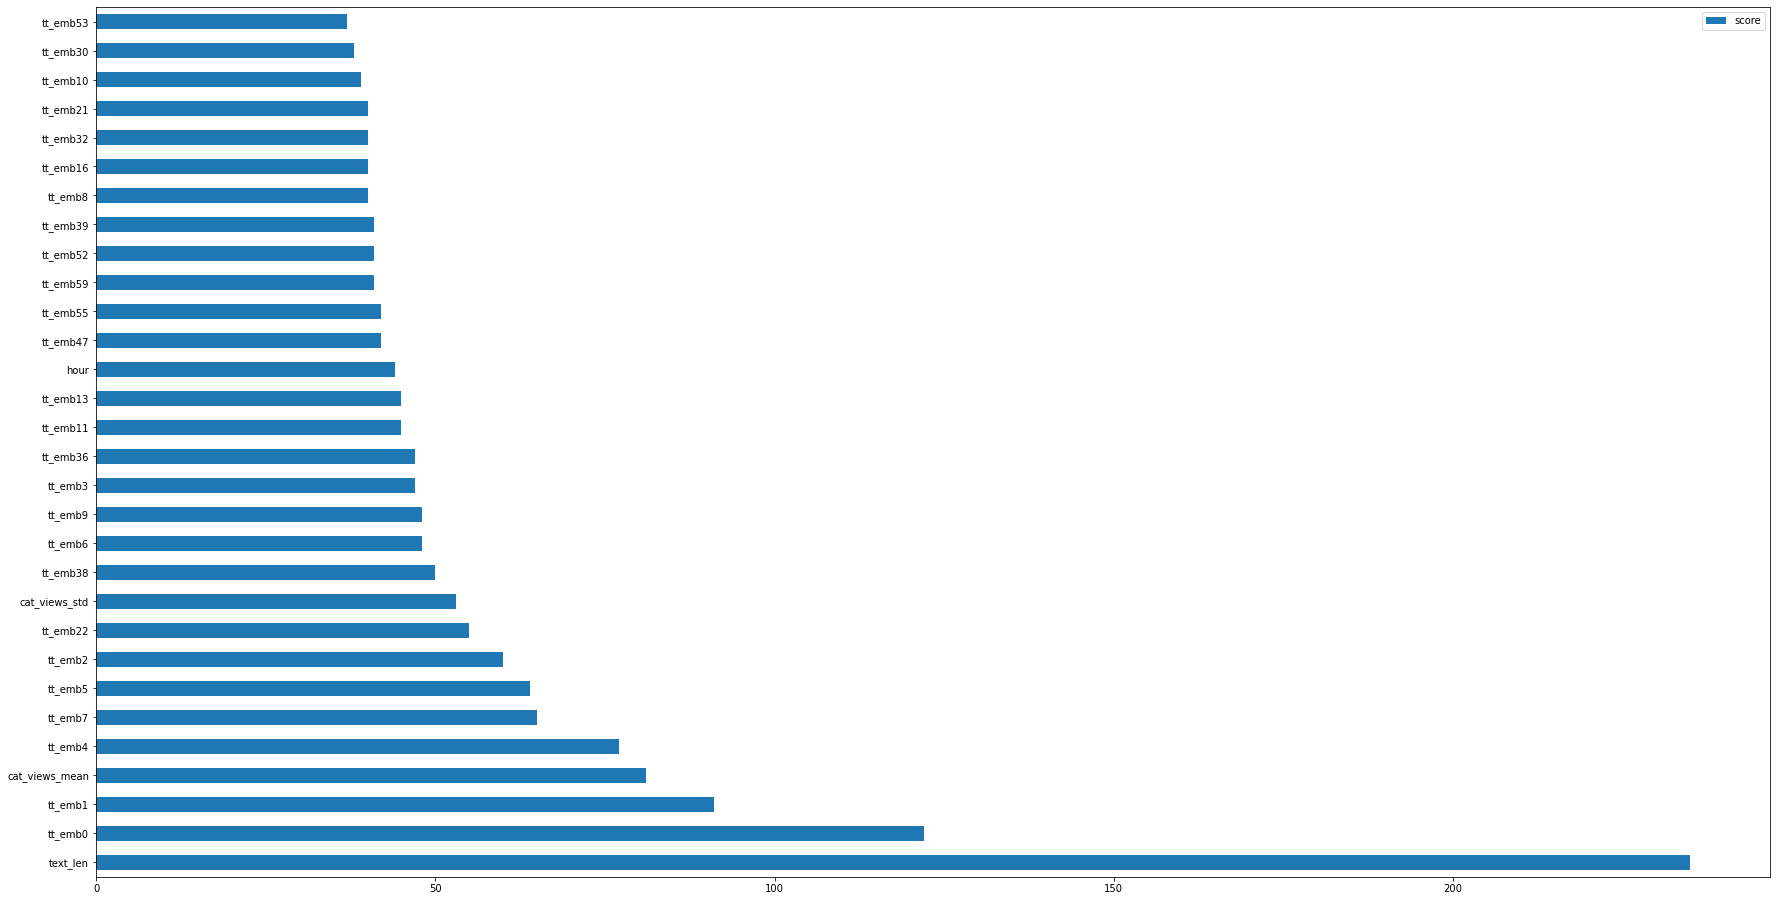

In [27]:
plot_importance(xgb_model_views, 30, 'weight')

## depth

In [28]:
cb_params_depth = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'n_estimators': 1000, 
    #'learning_rate': 0.05,
    'eta': 0.3,
    'max_depth': 15, 
 #   'num_boost_round': 10000, 
 #   'early_stopping_rounds': 100,
}
dtrain = xgb.DMatrix(df_train[num_cols], label=df_train[['depth']])

In [29]:
%%time
score = xgb.cv(cb_params_depth, dtrain, cv_ntrees, nfold=5, #early_stopping_rounds=1000,
        metrics={'rmse'},
        custom_metric = r2,
       #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
      )
score.tail()

Wall time: 21.3 s


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
95,0.000631,0.000086,0.022795,0.000502,0.99986,0.000037,0.820329,0.005755
96,0.000631,0.000086,0.022795,0.000502,0.99986,0.000037,0.820329,0.005755
97,0.000631,0.000086,0.022795,0.000502,0.99986,0.000037,0.820329,0.005755
98,0.000631,0.000086,0.022795,0.000502,0.99986,0.000037,0.820329,0.005755
99,0.000631,0.000086,0.022795,0.000502,0.99986,0.000037,0.820329,0.005755


In [30]:
score[score['train-r2-mean'] == score['train-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
35,0.000631,0.000086,0.022795,0.000502,0.99986,0.000037,0.820327,0.005756


In [31]:
score[score['test-r2-mean'] == score['test-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
25,0.000917,0.000126,0.022792,0.000505,0.999704,0.000079,0.82037,0.005813


In [32]:
xgb_model_depth = XGBRegressor(n_estimators=1000, 
                               max_depth=7, 
                               eta=0.1, 
                               #subsample=0.7, 
                               colsample_bytree=0.8,
                               n_jobs = -1,
                               random_state = XGB_RANDOMSEED,
                              )

xgb_model_depth.fit(x_train[num_cols], y_train['depth'], 
                    early_stopping_rounds=5,
                    eval_set=[(x_val[num_cols], y_val['depth'])], 
                    verbose=False
                   )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=56,
             reg_alpha=0, ...)

In [52]:
# Get predictions and metrics
preds_train_depth = xgb_model_depth.predict(x_train[num_cols])
preds_val_depth   = xgb_model_depth.predict(x_val[num_cols])

train_score_depth = r2_score(y_train["depth"], preds_train_depth)
val_score_depth   = r2_score(y_val["depth"],   preds_val_depth)

train_score_depth, val_score_depth

(0.9558236951502564, 0.8488129136027999)

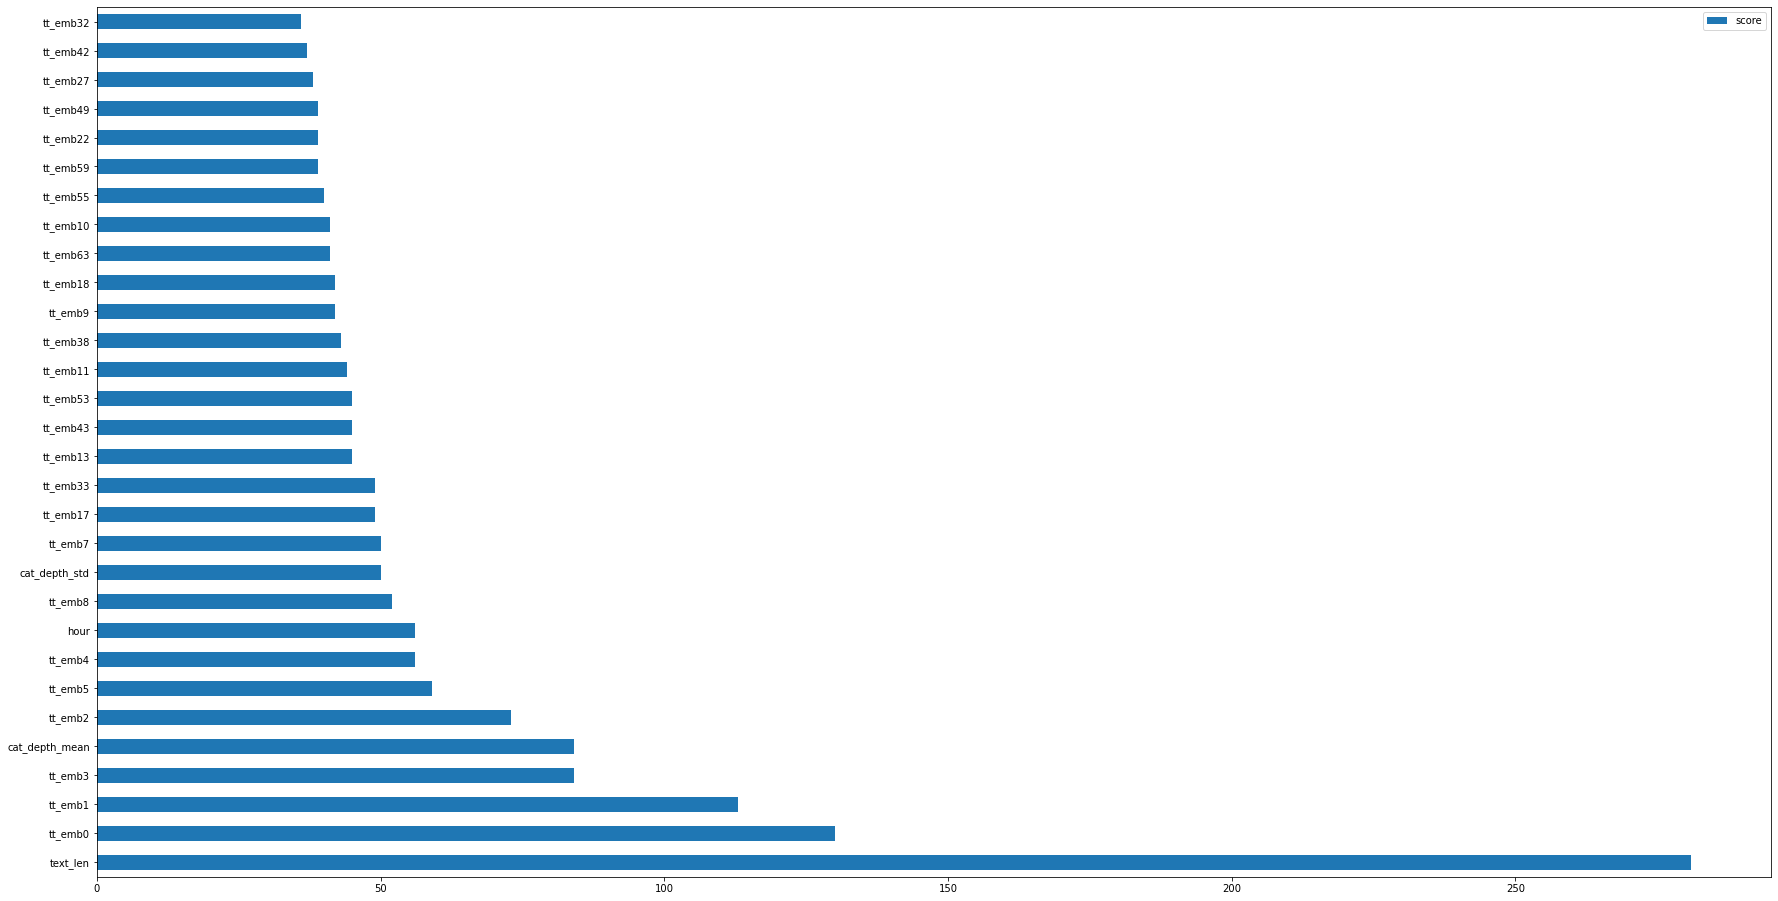

In [34]:
plot_importance(xgb_model_depth, 30, 'weight')

## full_reads_percent

In [35]:
cb_params_fpr = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'n_estimators': 1000, 
    #'learning_rate': 0.05,
    'eta': 0.3,
    'max_depth': 15, 
 #   'num_boost_round': 10000, 
 #   'early_stopping_rounds': 100,
}
dtrain = xgb.DMatrix(df_train[num_cols], label=df_train[['full_reads_percent']])

In [36]:
%%time
score = xgb.cv(cb_params_fpr, dtrain, cv_ntrees, nfold=5, #early_stopping_rounds=1000,
        metrics={'rmse'},
        custom_metric = r2,
       #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
      )
score.tail()

Wall time: 48.9 s


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
95,0.099163,0.028118,7.634056,0.118335,0.999889,0.000054,0.39189,0.016907
96,0.099163,0.028118,7.634056,0.118335,0.999889,0.000054,0.39189,0.016907
97,0.099163,0.028118,7.634056,0.118335,0.999889,0.000054,0.39189,0.016907
98,0.099163,0.028118,7.634056,0.118335,0.999889,0.000054,0.39189,0.016907
99,0.099163,0.028118,7.634056,0.118335,0.999889,0.000054,0.39189,0.016907


In [37]:
score[score['train-r2-mean'] == score['train-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
63,0.099166,0.028116,7.63406,0.11834,0.999889,0.000054,0.391889,0.016909


In [38]:
score[score['test-r2-mean'] == score['test-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
22,0.189738,0.024495,7.633954,0.119011,0.999618,0.000094,0.391903,0.017069


In [39]:
#pd.DataFrame(preds_train_depth, columns = ['depth_pred'])
pred_scaler = preprocessing.StandardScaler()
tmp = pred_scaler.fit_transform(preds_train_depth.reshape(-1, 1))
pred_depth_train = pd.DataFrame(tmp, columns = ['depth_pred'])

pred_depth_val   = pd.DataFrame(pred_scaler.transform(preds_val_depth.reshape(-1, 1)), columns = ['depth_pred'])


In [40]:
xgb_model_frp = XGBRegressor(n_estimators=1000, 
                             max_depth=7, 
                             eta=0.1, 
                             #subsample=0.7, 
                             colsample_bytree=0.8,
                             n_jobs = -1,
                             random_state = XGB_RANDOMSEED,
                             )

xgb_model_frp.fit(x_train[num_cols], 
                  y_train['full_reads_percent'], 
                  early_stopping_rounds=5,
                  eval_set=[(x_val[num_cols], 
                             y_val['full_reads_percent'])
                           ], 
                  verbose=False
                 )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=56,
             reg_alpha=0, ...)

In [41]:
# Get predictions and metrics
preds_train_frp = xgb_model_frp.predict(x_train[num_cols])
preds_val_frp   = xgb_model_frp.predict(x_val[num_cols])

train_score_frp = r2_score(y_train["full_reads_percent"], preds_train_frp)
val_score_frp   = r2_score(y_val["full_reads_percent"],   preds_val_frp)

train_score_frp, val_score_frp

(0.8742596378501758, 0.4701224235977286)

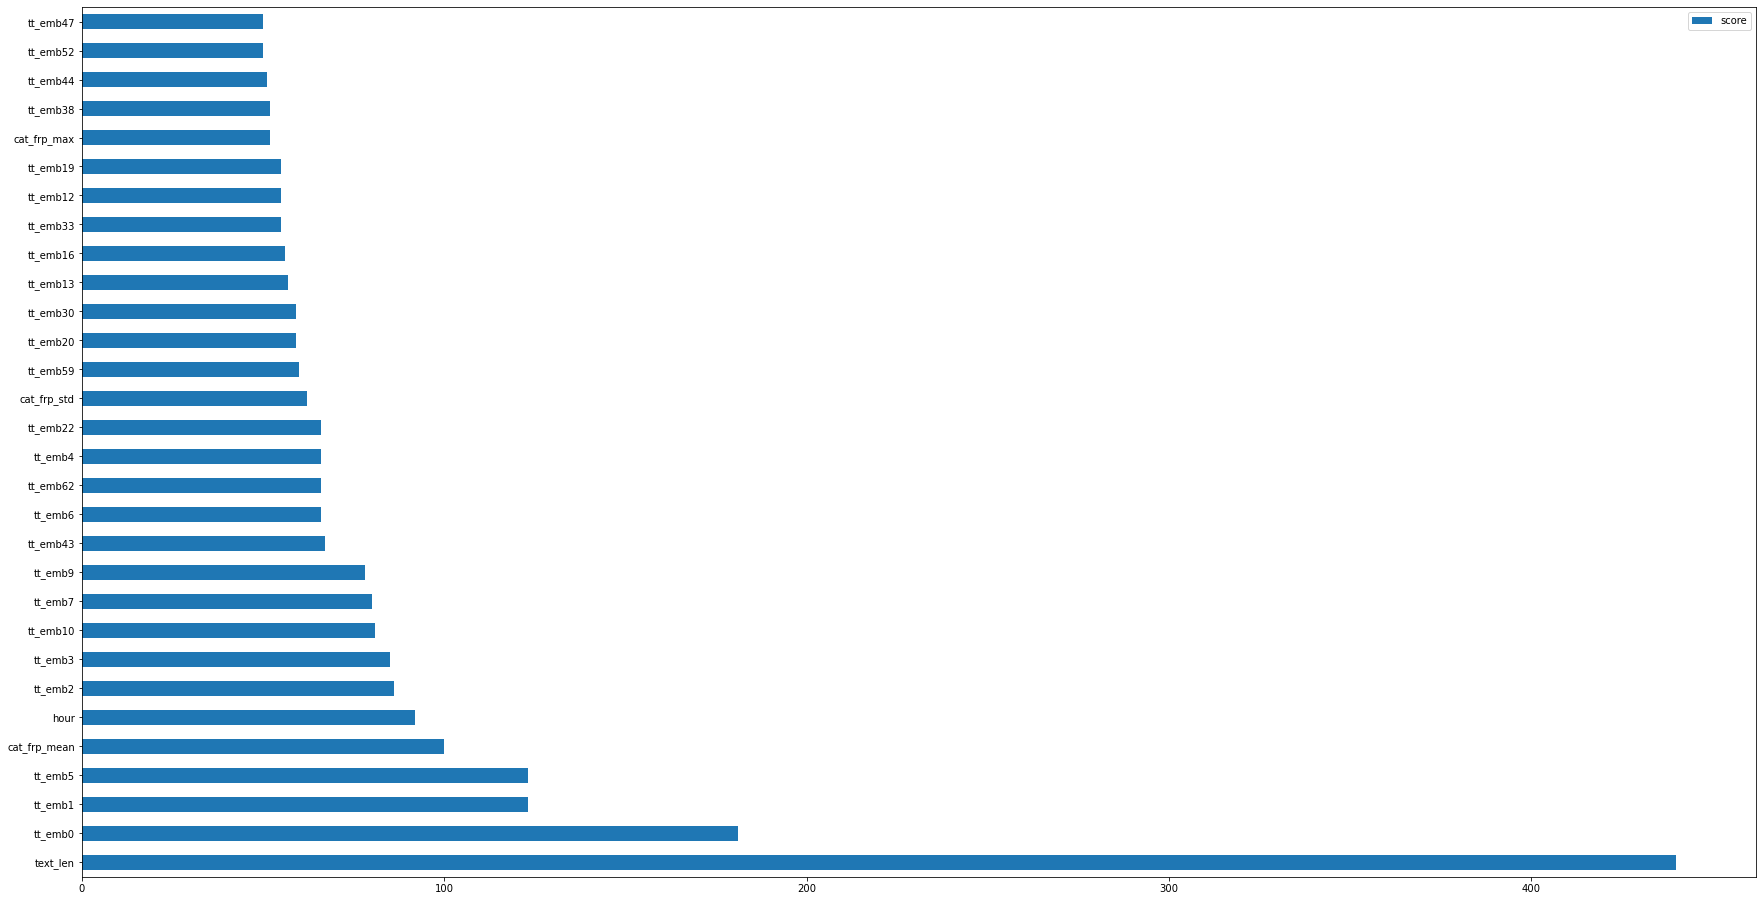

In [42]:
plot_importance(xgb_model_frp, 30, 'weight')

In [43]:
score_train = 0.4 * train_score_views + 0.3 * train_score_depth + 0.3 * train_score_frp
score_val   = 0.4 * val_score_views   + 0.3 * val_score_depth   + 0.3 * val_score_frp

score_train, score_val

(0.8617916648361333, 0.5527225453791871)

# Сохраняем предсказания для ансамблей / стекинга

In [44]:
x_train_pred = x_train[['document_id']]
x_val_pred   = x_val[['document_id']]

print('before ', x_train_pred.shape, preds_train_views.shape, preds_train_depth.shape, preds_train_frp.shape)
print('before ', x_val_pred.shape,   preds_val_views.shape,   preds_val_depth.shape,   preds_val_frp.shape)

# https://github.com/pandas-dev/pandas/issues/25349
x_train_pred = pd.concat([x_train_pred.reset_index(drop=True), 
                          pd.DataFrame(preds_train_views).reset_index(drop = True), 
                          pd.DataFrame(preds_train_depth).reset_index(drop = True), 
                          pd.DataFrame(preds_train_frp).reset_index(drop = True)
                         ], ignore_index = True, axis = 1)
x_val_pred   = pd.concat([x_val_pred.reset_index(drop=True),   
                          pd.DataFrame(preds_val_views).reset_index(drop = True), 
                          pd.DataFrame(preds_val_depth).reset_index(drop = True), 
                          pd.DataFrame(preds_val_frp).reset_index(drop = True)
                         ], ignore_index = True, axis = 1)

x_train_pred.columns = ['document_id', 'views_pred_xgb', 'depth_pred_xgb', 'frp_pred_xgb']
x_val_pred.columns   = ['document_id', 'views_pred_xgb', 'depth_pred_xgb', 'frp_pred_xgb']

print('after ', x_train_pred.shape)
print('after ', x_val_pred.shape)

x_train_pred.to_csv(os.path.join(DIR_SUBM_PART, f'{NAME}_train_part.csv'), index = False)
x_val_pred.to_csv(os.path.join(DIR_SUBM_PART, f'{NAME}_val_part.csv'), index = False)

before  (4930, 1) (4930,) (4930,) (4930,)
before  (1233, 1) (1233,) (1233,) (1233,)
after  (4930, 4)
after  (1233, 4)


## save models

In [45]:
xgb_model_views.save_model(os.path.join(DIR_MODELS, f'{NAME}_v.json'), 
                          )

xgb_model_depth.save_model(os.path.join(DIR_MODELS, f'{NAME}_d.json'), 
                          )

xgb_model_frp.save_model(os.path.join(DIR_MODELS, f'{NAME}_f.json'), 
                        )

## make predict

In [46]:
pred_views = xgb_model_views.predict(df_test[num_cols])
pred_depth = xgb_model_depth.predict(df_test[num_cols])
pred_frp   = xgb_model_frp.predict(  df_test[num_cols])

In [47]:
subm = pd.DataFrame()
subm['document_id'] = df_test.document_id

subm['views'] = pred_views
subm['depth'] = pred_depth
subm['full_reads_percent'] = pred_frp

In [48]:
doc_id_ukr = df_test[df_test.ctr == CTR_UKR].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,11187.028320,1.058278,15.876152
1440,30607.255859,1.167538,28.508272
2645,24722.183594,1.164644,27.432116


In [49]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [50]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,9950.909180,1.185940,43.483425
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,12052.850586,1.058638,32.544144
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,9481.916992,1.059513,27.823149
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,10230.704102,1.060621,36.630638
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,20227.697266,1.128364,33.459503


In [51]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME}.csv'), index = False)